<a href="https://colab.research.google.com/github/XQing-050103/CIFAR10_ResNet/blob/main/odmr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ========================================
# 单元格 1: 环境设置
# ========================================

print("🚀 开始设置环境...")

# 1. 安装必要的Python包
!pip install -q numpy pandas matplotlib seaborn

# 2. 检查GPU（可选，Astra-Sim不需要GPU）
import subprocess
gpu_info = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
if gpu_info.returncode == 0:
    print("✅ GPU可用（但本项目不需要GPU）")
else:
    print("ℹ️  无GPU（没关系，CPU足够）")

# 3. 检查系统资源
import psutil
print(f"✅ CPU核心数: {psutil.cpu_count()}")
print(f"✅ 可用内存: {psutil.virtual_memory().available / (1024**3):.2f} GB")
print(f"✅ 磁盘空间: {psutil.disk_usage('/').free / (1024**3):.2f} GB")

print("\n✅ 环境设置完成！")


🚀 开始设置环境...
✅ GPU可用（但本项目不需要GPU）
✅ CPU核心数: 2
✅ 可用内存: 11.41 GB
✅ 磁盘空间: 74.51 GB

✅ 环境设置完成！


In [2]:
# ========================================
# 单元格 2: 创建项目目录
# ========================================

import os
import shutil

# 创建目录结构
directories = [
    'astra_sim_workloads',
    'configs',
    'astra_sim_results',
    'extracted_data',
    'traffic_matrices',
    'visualizations'
]

print("📁 创建项目目录...")
for dir_name in directories:
    os.makedirs(dir_name, exist_ok=True)
    print(f"   ✅ {dir_name}/")

print("\n✅ 目录结构创建完成！")

# 显示目录树
!tree -L 2 -d 2>/dev/null || find . -type d -maxdepth 2 | head -20


📁 创建项目目录...
   ✅ astra_sim_workloads/
   ✅ configs/
   ✅ astra_sim_results/
   ✅ extracted_data/
   ✅ traffic_matrices/
   ✅ visualizations/

✅ 目录结构创建完成！
find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.
.
./.config
./.config/configurations
./.config/logs
./traffic_matrices
./astra_sim_workloads
./extracted_data
./visualizations
./drive
./drive/MyDrive
./drive/.shortcut-targets-by-id
./drive/.Trash-0
./drive/.Encrypted
./configs
./astra_sim_results
./sample_data


In [3]:
# ========================================
# Cell 3: Enhanced Workload Generator (Fixed PP + Multi-Topology)
# ========================================

import json
import numpy as np
from typing import Dict, List
import os

class EnhancedLightweightWorkloadV2:
    """
    增强版轻量级Workload生成器 V2
    优化点：
    1. 修复PP场景的非对称性（Send/Recv大小不同）
    2. 增加拓扑变体（3种）
    3. 保持轻量级（每个拓扑只生成关键场景）
    """

    def __init__(self, num_gpus=128):
        self.num_gpus = num_gpus

        # 保持5个关键场景
        self.key_scenarios = [
            "DP_steady",
            "PP_pipeline",
            "EP_experts",
            "MIXED_DP_PP",
            "MIXED_DP_EP"
        ]

        # 时间阶段配置
        self.time_phases = {
            'warmup': {'steps': 3, 'load_factor': 0.6},
            'steady': {'steps': 5, 'load_factor': 1.0},
            'cooldown': {'steps': 2, 'load_factor': 0.4}
        }

        # 新增：拓扑配置（轻量级：只生成3种代表性拓扑）
        self.topologies = {
            'fat_tree': {
                'name': 'Fat-Tree',
                'bandwidth_factor': 1.0,  # 基准带宽
                'latency_factor': 1.0,    # 基准延迟
                'description': 'Traditional data center topology'
            },
            'dragonfly': {
                'name': 'Dragonfly',
                'bandwidth_factor': 1.2,  # 20%更高带宽
                'latency_factor': 0.8,    # 20%更低延迟
                'description': 'Low-diameter high-radix topology'
            },
            'torus': {
                'name': 'Torus',
                'bandwidth_factor': 0.9,  # 10%更低带宽
                'latency_factor': 1.1,    # 10%更高延迟
                'description': 'Mesh-based topology'
            }
        }

    def generate_enhanced_workload(self, scenario: str, phase: str, topology: str):
        """生成增强版workload配置"""

        phase_config = self.time_phases[phase]
        topo_config = self.topologies[topology]

        num_steps = phase_config['steps']
        load_factor = phase_config['load_factor']
        bw_factor = topo_config['bandwidth_factor']

        workload_base = {
            "name": f"{scenario}_{phase}_{topology}",
            "num_npus": self.num_gpus,
            "num_passes": num_steps,
            "phase": phase,
            "topology": topology,
            "load_factor": load_factor,
            "bandwidth_factor": bw_factor,
            "layers": []
        }

        if scenario == "DP_steady":
            # 数据并行：保持对称
            workload_base["layers"] = [
                {
                    "id": 0,
                    "name": "dp_layer_0",
                    "type": "COMP",
                    "fwd_pass": {"comp_time": 1, "comm": []},
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 0,
                            "type": "ALLREDUCE",
                            "size": int(50 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"data_parallel": self.num_gpus}
                        }]
                    }
                },
                {
                    "id": 1,
                    "name": "dp_layer_1",
                    "type": "COMP",
                    "fwd_pass": {"comp_time": 1, "comm": []},
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 1,
                            "type": "ALLREDUCE",
                            "size": int(30 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"data_parallel": self.num_gpus}
                        }]
                    }
                }
            ]

        elif scenario == "PP_pipeline":
            # 🔧 关键修复：流水线并行 - 增强非对称性
            num_stages = 8
            layers = []
            for stage in range(num_stages):
                # 前向传播：大消息（激活值）
                fwd_size = int(15 * 1024 * 1024 * load_factor * bw_factor)
                # 反向传播：小消息（梯度） - 关键：非对称
                bwd_size = int(5 * 1024 * 1024 * load_factor * bw_factor)

                layers.append({
                    "id": stage,
                    "name": f"pp_stage_{stage}",
                    "type": "COMP",
                    "fwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": stage,
                            "type": "SEND",
                            "size": fwd_size,  # 大消息
                            "src": stage,
                            "dst": stage + 1,
                            "involved_dim": {"pipeline_parallel": num_stages}
                        }] if stage < num_stages - 1 else []
                    },
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": stage + num_stages,
                            "type": "SEND",
                            "size": bwd_size,  # 小消息（非对称）
                            "src": stage,
                            "dst": stage - 1,
                            "involved_dim": {"pipeline_parallel": num_stages}
                        }] if stage > 0 else []
                    }
                })
            workload_base["layers"] = layers

        elif scenario == "EP_experts":
            # 专家并行：保持对称
            num_experts = 64
            workload_base["layers"] = [
                {
                    "id": 0,
                    "name": "moe_layer_0",
                    "type": "MOE",
                    "fwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 0,
                            "type": "ALLTOALL",
                            "size": int(30 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"expert_parallel": num_experts}
                        }]
                    },
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 1,
                            "type": "ALLTOALL",
                            "size": int(30 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"expert_parallel": num_experts}
                        }]
                    }
                },
                {
                    "id": 1,
                    "name": "moe_layer_1",
                    "type": "MOE",
                    "fwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 2,
                            "type": "ALLTOALL",
                            "size": int(20 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"expert_parallel": num_experts}
                        }]
                    },
                    "bwd_pass": {"comp_time": 1, "comm": []}
                }
            ]

        elif scenario == "MIXED_DP_PP":
            # 🔧 关键修复：混合并行 - 增强非对称性
            num_stages = 4
            dp_size = self.num_gpus // num_stages

            layers = []
            for stage in range(num_stages):
                # PP部分：非对称Send/Recv
                fwd_size = int(20 * 1024 * 1024 * load_factor * bw_factor)
                bwd_size = int(8 * 1024 * 1024 * load_factor * bw_factor)

                layers.append({
                    "id": stage,
                    "name": f"mixed_dp_pp_stage_{stage}",
                    "type": "COMP",
                    "fwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": stage,
                            "type": "SEND",
                            "size": fwd_size,  # 大消息
                            "src": stage * dp_size,
                            "dst": (stage + 1) * dp_size,
                            "involved_dim": {"pipeline_parallel": num_stages}
                        }] if stage < num_stages - 1 else []
                    },
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [
                            {
                                "id": stage + num_stages,
                                "type": "SEND",
                                "size": bwd_size,  # 小消息（非对称）
                                "src": stage * dp_size,
                                "dst": (stage - 1) * dp_size if stage > 0 else 0,
                                "involved_dim": {"pipeline_parallel": num_stages}
                            },
                            {
                                "id": stage + 2 * num_stages,
                                "type": "ALLREDUCE",
                                "size": int(40 * 1024 * 1024 * load_factor * bw_factor),
                                "involved_dim": {"data_parallel": dp_size}
                            }
                        ]
                    }
                })
            workload_base["layers"] = layers

        elif scenario == "MIXED_DP_EP":
            # 混合并行：保持对称
            num_experts = 64
            dp_size = self.num_gpus // 2

            workload_base["layers"] = [
                {
                    "id": 0,
                    "name": "mixed_moe_layer_0",
                    "type": "MOE",
                    "fwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 0,
                            "type": "ALLTOALL",
                            "size": int(35 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"expert_parallel": num_experts}
                        }]
                    },
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [
                            {
                                "id": 1,
                                "type": "ALLTOALL",
                                "size": int(35 * 1024 * 1024 * load_factor * bw_factor),
                                "involved_dim": {"expert_parallel": num_experts}
                            },
                            {
                                "id": 2,
                                "type": "ALLREDUCE",
                                "size": int(50 * 1024 * 1024 * load_factor * bw_factor),
                                "involved_dim": {"data_parallel": dp_size}
                            }
                        ]
                    }
                },
                {
                    "id": 1,
                    "name": "mixed_moe_layer_1",
                    "type": "MOE",
                    "fwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 3,
                            "type": "ALLTOALL",
                            "size": int(25 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"expert_parallel": num_experts}
                        }]
                    },
                    "bwd_pass": {
                        "comp_time": 1,
                        "comm": [{
                            "id": 4,
                            "type": "ALLREDUCE",
                            "size": int(30 * 1024 * 1024 * load_factor * bw_factor),
                            "involved_dim": {"data_parallel": dp_size}
                        }]
                    }
                }
            ]

        return workload_base

    def export_all_scenarios_multi_topology(self, output_dir="./astra_sim_workloads"):
        """导出所有场景的多拓扑配置（轻量级版本）"""
        os.makedirs(output_dir, exist_ok=True)

        print("=" * 70)
        print("Enhanced Astra-Sim Workload Generation V2 (Multi-Topology)")
        print("=" * 70)
        print(f"GPU Count: {self.num_gpus}")
        print(f"Scenarios: {len(self.key_scenarios)}")
        print(f"Phases: {list(self.time_phases.keys())}")
        print(f"Topologies: {list(self.topologies.keys())}")
        print(f"Total Configs: {len(self.key_scenarios) * len(self.time_phases) * len(self.topologies)}")
        print("=" * 70)

        all_configs = []

        for topology in self.topologies.keys():
            print(f"\n🌐 Topology: {self.topologies[topology]['name']}")

            for scenario in self.key_scenarios:
                print(f"  📦 Scenario: {scenario}")

                for phase in self.time_phases.keys():
                    workload = self.generate_enhanced_workload(scenario, phase, topology)

                    output_file = f"{output_dir}/{scenario}_{phase}_{topology}.json"
                    with open(output_file, "w") as f:
                        json.dump(workload, f, indent=2)

                    config_name = f"{scenario}_{phase}_{topology}"
                    all_configs.append(config_name)

                    steps = self.time_phases[phase]['steps']
                    load = self.time_phases[phase]['load_factor']
                    bw = self.topologies[topology]['bandwidth_factor']
                    print(f"     ✅ {phase:10s} -> {steps} steps, load={load:.1f}, bw={bw:.1f}x")

        print(f"\n✅ Generated {len(all_configs)} configurations")
        print(f"   - 5 scenarios × 3 phases × 3 topologies = 45 configs")
        return all_configs

# 运行生成器
print("🚀 Starting enhanced workload generation V2...")
generator = EnhancedLightweightWorkloadV2(num_gpus=128)
all_configs = generator.export_all_scenarios_multi_topology()

print("\n📋 Sample Configurations (first 10):")
for i, config in enumerate(all_configs[:10], 1):
    print(f"   {i:2d}. {config}")
print(f"   ... ({len(all_configs) - 10} more)")

# 清理内存
import gc
del generator
gc.collect()
print("\n✅ Memory cleaned")


🚀 Starting enhanced workload generation V2...
Enhanced Astra-Sim Workload Generation V2 (Multi-Topology)
GPU Count: 128
Scenarios: 5
Phases: ['warmup', 'steady', 'cooldown']
Topologies: ['fat_tree', 'dragonfly', 'torus']
Total Configs: 45

🌐 Topology: Fat-Tree
  📦 Scenario: DP_steady
     ✅ warmup     -> 3 steps, load=0.6, bw=1.0x
     ✅ steady     -> 5 steps, load=1.0, bw=1.0x
     ✅ cooldown   -> 2 steps, load=0.4, bw=1.0x
  📦 Scenario: PP_pipeline
     ✅ warmup     -> 3 steps, load=0.6, bw=1.0x
     ✅ steady     -> 5 steps, load=1.0, bw=1.0x
     ✅ cooldown   -> 2 steps, load=0.4, bw=1.0x
  📦 Scenario: EP_experts
     ✅ warmup     -> 3 steps, load=0.6, bw=1.0x
     ✅ steady     -> 5 steps, load=1.0, bw=1.0x
     ✅ cooldown   -> 2 steps, load=0.4, bw=1.0x
  📦 Scenario: MIXED_DP_PP
     ✅ warmup     -> 3 steps, load=0.6, bw=1.0x
     ✅ steady     -> 5 steps, load=1.0, bw=1.0x
     ✅ cooldown   -> 2 steps, load=0.4, bw=1.0x
  📦 Scenario: MIXED_DP_EP
     ✅ warmup     -> 3 steps, load=0

In [4]:
# ========================================
# Cell 4: Enhanced Astra-Sim Simulator V2 (Burst Traffic)
# ========================================

import numpy as np
import json
from datetime import datetime
import gc
import os

class EnhancedAstraSimSimulatorV2:
    """
    增强版Astra-Sim模拟器 V2
    优化点：
    1. 添加随机突发流量（burst traffic）
    2. 支持多拓扑配置
    3. 保持流式处理（内存友好）
    """

    def __init__(self, num_gpus=128):
        self.num_gpus = num_gpus
        self.bandwidth_gbps = 200
        self.latency_us = 5
        self.bandwidth_bytes_per_us = (self.bandwidth_gbps * 1e9 / 8) / 1e6

        # 新增：突发流量配置
        self.burst_config = {
            'probability': 0.3,  # 30%概率发生突发
            'min_factor': 1.5,   # 最小突发倍数
            'max_factor': 3.0    # 最大突发倍数
        }

    def _get_burst_factor(self, step, phase):
        """
        生成突发流量因子
        策略：
        1. Warmup阶段：较少突发（10%概率）
        2. Steady阶段：正常突发（30%概率）
        3. Cooldown阶段：较少突发（10%概率）
        """
        # 根据阶段调整突发概率
        if phase == 'warmup' or phase == 'cooldown':
            prob = 0.1
        else:
            prob = self.burst_config['probability']

        # 随机决定是否突发
        if np.random.random() < prob:
            # 生成突发倍数（1.5x - 3.0x）
            burst_factor = np.random.uniform(
                self.burst_config['min_factor'],
                self.burst_config['max_factor']
            )
            return burst_factor
        else:
            return 1.0

    def simulate_scenario(self, workload_file, output_dir):
        """模拟单个场景（流式处理 + 突发流量）"""

        # 读取workload配置
        with open(workload_file, 'r') as f:
            workload = json.load(f)

        scenario_name = workload['name']
        num_steps = workload['num_passes']
        layers = workload['layers']
        phase = workload.get('phase', 'steady')
        load_factor = workload.get('load_factor', 1.0)
        topology = workload.get('topology', 'fat_tree')
        bw_factor = workload.get('bandwidth_factor', 1.0)

        # 创建输出目录
        scenario_dir = f"{output_dir}/{scenario_name}"
        os.makedirs(scenario_dir, exist_ok=True)

        # 打开日志文件（流式写入）
        log_file = f"{scenario_dir}/comm.txt"

        total_comms = 0
        total_bytes = 0
        burst_events = 0

        with open(log_file, 'w') as f:
            current_time = 0.0

            # 逐步生成通信记录
            for step in range(num_steps):
                # 🔧 关键新增：生成突发流量因子
                burst_factor = self._get_burst_factor(step, phase)
                if burst_factor > 1.0:
                    burst_events += 1

                for layer in layers:
                    # 处理前向传播
                    if 'fwd_pass' in layer:
                        for comm in layer['fwd_pass'].get('comm', []):
                            entries = self._generate_comm_entries(
                                comm, current_time, scenario_name,
                                burst_factor=burst_factor,
                                bw_factor=bw_factor
                            )
                            for entry in entries:
                                f.write(f"sys[{entry['sys_id']}] time: {entry['time']:.6f} "
                                       f"src: {entry['src']} dst: {entry['dst']} "
                                       f"size: {entry['size']} type: {entry['type']}\n")
                                total_comms += 1
                                total_bytes += entry['size']
                            if entries:
                                current_time = max([e['time'] for e in entries])

                    # 处理反向传播
                    if 'bwd_pass' in layer:
                        for comm in layer['bwd_pass'].get('comm', []):
                            entries = self._generate_comm_entries(
                                comm, current_time, scenario_name,
                                burst_factor=burst_factor,
                                bw_factor=bw_factor
                            )
                            for entry in entries:
                                f.write(f"sys[{entry['sys_id']}] time: {entry['time']:.6f} "
                                       f"src: {entry['src']} dst: {entry['dst']} "
                                       f"size: {entry['size']} type: {entry['type']}\n")
                                total_comms += 1
                                total_bytes += entry['size']
                            if entries:
                                current_time = max([e['time'] for e in entries])

                # 每步之后清理内存
                if step % 2 == 0:
                    gc.collect()

        # 生成统计信息
        stats = {
            'scenario': scenario_name,
            'phase': phase,
            'topology': topology,
            'load_factor': load_factor,
            'bandwidth_factor': bw_factor,
            'total_communications': total_comms,
            'total_bytes': total_bytes,
            'total_bytes_mb': total_bytes / (1024 ** 2),
            'total_time_ms': current_time,
            'avg_bandwidth_gbps': (total_bytes * 8 / 1e9) / (current_time / 1000) if current_time > 0 else 0,
            'burst_events': burst_events,
            'burst_ratio': burst_events / num_steps if num_steps > 0 else 0
        }

        stats_file = f"{scenario_dir}/stats.json"
        with open(stats_file, 'w') as f:
            json.dump(stats, f, indent=2)

        return total_comms, stats

    def _generate_comm_entries(self, comm, start_time, scenario_name, burst_factor=1.0, bw_factor=1.0):
        """生成通信条目（增强采样 + 突发流量）"""
        comm_type = comm.get('type', 'NONE')
        entries = []

        # 应用突发流量因子和带宽因子
        size = int(comm['size'] * burst_factor * bw_factor)

        if comm_type == 'ALLREDUCE':
            # 增加采样密度：64
            sample_size = min(self.num_gpus, 64)
            for i in range(sample_size):
                src = i
                dst = (i + 1) % self.num_gpus
                transfer_time = (size / self.bandwidth_bytes_per_us + self.latency_us)
                entries.append({
                    'sys_id': 0,
                    'time': start_time + transfer_time,
                    'src': src,
                    'dst': dst,
                    'size': size // self.num_gpus,
                    'type': 'ALLREDUCE'
                })

        elif comm_type == 'SEND':
            src = comm.get('src', 0)
            dst = comm.get('dst', 1)
            transfer_time = size / self.bandwidth_bytes_per_us + self.latency_us
            entries.append({
                'sys_id': 0,
                'time': start_time + transfer_time,
                'src': src,
                'dst': dst,
                'size': size,
                'type': 'SEND'
            })

        elif comm_type == 'ALLTOALL':
            num_experts = comm.get('involved_dim', {}).get('expert_parallel', 64)
            # 增加采样密度：16
            sample_size = min(num_experts, 16)
            for i in range(sample_size):
                for j in range(sample_size):
                    if i != j:
                        transfer_time = size / self.bandwidth_bytes_per_us + self.latency_us
                        entries.append({
                            'sys_id': 0,
                            'time': start_time + transfer_time,
                            'src': i,
                            'dst': j,
                            'size': size // num_experts,
                            'type': 'ALLTOALL'
                        })

        return entries

# 运行模拟器
print("=" * 70)
print("Enhanced Astra-Sim Simulation V2 (Burst Traffic + Multi-Topology)")
print("=" * 70)

simulator = EnhancedAstraSimSimulatorV2(num_gpus=128)

results = []
total_configs = len(all_configs)

# 分批处理（每15个配置清理一次内存）
batch_size = 15
for batch_start in range(0, total_configs, batch_size):
    batch_end = min(batch_start + batch_size, total_configs)
    batch_configs = all_configs[batch_start:batch_end]

    print(f"\n📦 Processing batch {batch_start//batch_size + 1}/{(total_configs + batch_size - 1)//batch_size}")

    for i, config in enumerate(batch_configs):
        global_idx = batch_start + i
        workload_file = f"./astra_sim_workloads/{config}.json"

        # 提取场景、阶段和拓扑
        parts = config.rsplit('_', 2)
        scenario = parts[0] if len(parts) > 2 else config
        phase = parts[1] if len(parts) > 2 else 'steady'
        topology = parts[2] if len(parts) > 2 else 'fat_tree'

        print(f"  🚀 [{global_idx+1}/{total_configs}] {config}")

        num_comms, stats = simulator.simulate_scenario(
            workload_file,
            "./astra_sim_results"
        )

        print(f"     ✅ Comms: {num_comms}, Traffic: {stats['total_bytes_mb']:.1f} MB, "
              f"Bursts: {stats['burst_events']}/{stats['burst_events'] + (5 - stats['burst_events'])}")

        results.append({
            'config': config,
            'scenario': scenario,
            'phase': phase,
            'topology': topology,
            'num_communications': num_comms,
            'total_mb': stats['total_bytes_mb'],
            'avg_bandwidth_gbps': stats['avg_bandwidth_gbps'],
            'burst_events': stats['burst_events']
        })

    # 批次结束后清理内存
    gc.collect()
    print(f"  ✅ Batch {batch_start//batch_size + 1} completed, memory cleaned")

print("\n" + "=" * 70)
print("✅ Simulation Complete!")
print("=" * 70)

# 显示汇总
import pandas as pd
df_results = pd.DataFrame(results)
print("\n📊 Simulation Results Summary:")
print(df_results[['config', 'total_mb', 'burst_events']].head(10))
print(f"... ({len(df_results) - 10} more rows)")

# 按拓扑分组统计
print("\n📊 Traffic by Topology:")
topo_stats = df_results.groupby('topology')['total_mb'].agg(['mean', 'min', 'max'])
print(topo_stats)

# 按阶段分组统计
print("\n📊 Traffic by Phase:")
phase_stats = df_results.groupby('phase')['total_mb'].agg(['mean', 'min', 'max'])
print(phase_stats)

# 突发流量统计
print("\n📊 Burst Traffic Statistics:")
print(f"Total burst events: {df_results['burst_events'].sum()}")
print(f"Avg burst events per config: {df_results['burst_events'].mean():.2f}")

# 清理内存
del simulator
gc.collect()
print("\n✅ Memory cleaned")


Enhanced Astra-Sim Simulation V2 (Burst Traffic + Multi-Topology)

📦 Processing batch 1/3
  🚀 [1/45] DP_steady_warmup_fat_tree
     ✅ Comms: 384, Traffic: 116.7 MB, Bursts: 1/5
  🚀 [2/45] DP_steady_steady_fat_tree
     ✅ Comms: 640, Traffic: 276.2 MB, Bursts: 1/5
  🚀 [3/45] DP_steady_cooldown_fat_tree
     ✅ Comms: 256, Traffic: 32.0 MB, Bursts: 0/5
  🚀 [4/45] PP_pipeline_warmup_fat_tree
     ✅ Comms: 42, Traffic: 252.0 MB, Bursts: 0/5
  🚀 [5/45] PP_pipeline_steady_fat_tree
     ✅ Comms: 70, Traffic: 897.8 MB, Bursts: 1/5
  🚀 [6/45] PP_pipeline_cooldown_fat_tree
     ✅ Comms: 28, Traffic: 112.0 MB, Bursts: 0/5
  🚀 [7/45] EP_experts_warmup_fat_tree
     ✅ Comms: 2160, Traffic: 540.0 MB, Bursts: 0/5
  🚀 [8/45] EP_experts_steady_fat_tree
     ✅ Comms: 3600, Traffic: 1500.0 MB, Bursts: 0/5
  🚀 [9/45] EP_experts_cooldown_fat_tree
     ✅ Comms: 1440, Traffic: 240.0 MB, Bursts: 0/5
  🚀 [10/45] MIXED_DP_PP_warmup_fat_tree
     ✅ Comms: 789, Traffic: 309.6 MB, Bursts: 0/5
  🚀 [11/45] MIXED_DP_P

In [5]:
# ========================================
# Cell 5: Enhanced Traffic Matrix Extraction V2 (Multi-Topology)
# ========================================

import numpy as np
import pandas as pd
from pathlib import Path
import os
import gc

class EnhancedTrafficMatrixExtractorV2:
    """增强版流量矩阵提取器 V2（支持多拓扑 + 突发流量特征）"""

    def __init__(self, result_dir, num_gpus=128):
        self.result_dir = result_dir
        self.num_gpus = num_gpus

    def parse_comm_log_streaming(self, log_file):
        """流式解析通信日志"""

        with open(log_file, 'r') as f:
            for line in f:
                if 'src:' in line and 'dst:' in line:
                    parts = line.split()
                    try:
                        yield {
                            'timestamp': float(parts[2]),
                            'src': int(parts[4]),
                            'dst': int(parts[6]),
                            'size_bytes': int(parts[8]),
                            'type': parts[10]
                        }
                    except:
                        continue

    def build_traffic_matrix_streaming(self, log_file, time_window=1.0):
        """流式构建流量矩阵"""

        # 初始化矩阵
        matrix = np.zeros((self.num_gpus, self.num_gpus), dtype=np.float32)

        for comm in self.parse_comm_log_streaming(log_file):
            src = min(comm['src'], self.num_gpus - 1)
            dst = min(comm['dst'], self.num_gpus - 1)
            size_mb = comm['size_bytes'] / (1024 ** 2)

            matrix[src, dst] += size_mb

        # 转换为MB/s
        matrix = matrix / time_window

        return matrix

    def extract_enhanced_features(self, matrix, scenario_name, phase, topology, stats):
        """提取增强特征（包含拓扑和突发流量信息）"""
        flat = matrix.flatten()
        flat_nonzero = flat[flat > 0]

        features = {
            'scenario': scenario_name,
            'phase': phase,
            'topology': topology,
            'config': f"{scenario_name}_{phase}_{topology}",

            # 基础流量特征
            'total_traffic_mb_per_sec': float(np.sum(matrix)),
            'avg_traffic': float(np.mean(matrix)),
            'max_traffic': float(np.max(matrix)),
            'std_traffic': float(np.std(matrix)),
            'median_traffic': float(np.median(flat_nonzero)) if len(flat_nonzero) > 0 else 0.0,

            # 稀疏性特征
            'sparsity': float(np.sum(matrix == 0) / matrix.size),
            'non_zero_ratio': float(np.count_nonzero(matrix) / matrix.size),
            'non_zero_count': int(np.count_nonzero(matrix)),

            # 热点特征
            'max_node_send_traffic': float(np.max(matrix.sum(axis=1))),
            'max_node_recv_traffic': float(np.max(matrix.sum(axis=0))),
            'avg_node_send_traffic': float(np.mean(matrix.sum(axis=1))),
            'avg_node_recv_traffic': float(np.mean(matrix.sum(axis=0))),
            'top_10_nodes_traffic': float(np.sum(np.sort(matrix.sum(axis=1))[-10:])),
            'top_10_ratio': float(np.sum(np.sort(matrix.sum(axis=1))[-10:]) / np.sum(matrix)) if np.sum(matrix) > 0 else 0.0,

            # 对称性特征（关键改进）
            'symmetry_score': float(np.mean(np.abs(matrix - matrix.T))),
            'asymmetry_ratio': float(np.sum(np.abs(matrix - matrix.T)) / (2 * np.sum(matrix))) if np.sum(matrix) > 0 else 0.0,

            # 分布特征
            'traffic_range': float(np.max(matrix) - np.min(flat_nonzero)) if len(flat_nonzero) > 0 else 0.0,
            'traffic_iqr': float(np.percentile(flat_nonzero, 75) - np.percentile(flat_nonzero, 25)) if len(flat_nonzero) > 0 else 0.0,

            # 🔧 新增：突发流量特征
            'burst_events': stats.get('burst_events', 0),
            'burst_ratio': stats.get('burst_ratio', 0.0),
        }

        # 高阶统计特征
        if len(flat_nonzero) > 0:
            mean = np.mean(flat_nonzero)
            std = np.std(flat_nonzero)
            if std > 0:
                features['traffic_skewness'] = float(np.mean(((flat_nonzero - mean) / std) ** 3))
                features['traffic_kurtosis'] = float(np.mean(((flat_nonzero - mean) / std) ** 4) - 3)
                features['coefficient_of_variation'] = float(std / mean)
            else:
                features['traffic_skewness'] = 0.0
                features['traffic_kurtosis'] = 0.0
                features['coefficient_of_variation'] = 0.0
        else:
            features['traffic_skewness'] = 0.0
            features['traffic_kurtosis'] = 0.0
            features['coefficient_of_variation'] = 0.0

        # 拓扑特征（用于Pareto优化）
        features['hotspot_concentration'] = float(features['top_10_ratio'])
        features['load_balance_score'] = 1.0 - float(np.std(matrix.sum(axis=1)) / np.mean(matrix.sum(axis=1))) if np.mean(matrix.sum(axis=1)) > 0 else 0.0

        return features

    def extract_all_scenarios(self, output_dir="./extracted_data"):
        """提取所有场景（分批处理）"""
        os.makedirs(output_dir, exist_ok=True)

        all_data = []
        all_matrices = {}

        print("=" * 70)
        print("Enhanced Traffic Matrix Extraction V2 (Multi-Topology)")
        print("=" * 70)

        if not os.path.exists(self.result_dir):
            print(f"❌ Error: Result directory not found: {self.result_dir}")
            return pd.DataFrame(), {}

        scenario_dirs = list(Path(self.result_dir).iterdir())
        total_scenarios = len([d for d in scenario_dirs if d.is_dir()])

        print(f"Total scenarios to process: {total_scenarios}")

        # 分批处理（每10个场景清理一次内存）
        batch_size = 10
        processed = 0

        for scenario_dir in scenario_dirs:
            if not scenario_dir.is_dir():
                continue

            config_name = scenario_dir.name

            # 解析场景、阶段和拓扑
            parts = config_name.rsplit('_', 2)
            scenario = parts[0] if len(parts) > 2 else config_name
            phase = parts[1] if len(parts) > 2 else 'steady'
            topology = parts[2] if len(parts) > 2 else 'fat_tree'

            processed += 1
            print(f"\n📊 [{processed}/{total_scenarios}] Processing: {config_name}")
            print(f"   Scenario: {scenario}, Phase: {phase}, Topology: {topology}")

            log_file = scenario_dir / "comm.txt"
            stats_file = scenario_dir / "stats.json"

            if not log_file.exists():
                print(f"   ⚠️  Log file not found")
                continue

            # 读取统计信息
            stats = {}
            if stats_file.exists():
                import json
                with open(stats_file, 'r') as f:
                    stats = json.load(f)

            # 流式构建流量矩阵
            matrix = self.build_traffic_matrix_streaming(log_file, time_window=1.0)
            print(f"   ✅ Matrix shape: {matrix.shape}")
            print(f"   ✅ Total traffic: {np.sum(matrix):.2f} MB/s")

            # 保存矩阵（轻量级：只保存关键场景）
            if phase == 'steady':  # 只保存steady阶段的矩阵
                matrix_file = f"{output_dir}/matrix_{config_name}.npy"
                np.save(matrix_file, matrix)
                all_matrices[config_name] = matrix

            # 提取特征
            features = self.extract_enhanced_features(matrix, scenario, phase, topology, stats)
            all_data.append(features)

            # 显示关键指标
            print(f"   ✅ Sparsity: {features['sparsity']:.2%}")
            print(f"   ✅ Asymmetry: {features['asymmetry_ratio']:.4f}")
            print(f"   ✅ Burst events: {features['burst_events']}")

            # 清理内存
            del matrix

            # 每批次后清理内存
            if processed % batch_size == 0:
                gc.collect()
                print(f"   🧹 Memory cleaned (batch {processed // batch_size})")

        # 保存为CSV
        if all_data:
            df = pd.DataFrame(all_data)
            csv_file = f"{output_dir}/training_data_enhanced_v2.csv"
            df.to_csv(csv_file, index=False)

            print("\n" + "=" * 70)
            print("✅ Extraction Complete!")
            print("=" * 70)
            print(f"✅ Total Samples: {len(all_data)}")
            print(f"✅ Unique Scenarios: {df['scenario'].nunique()}")
            print(f"✅ Phases: {df['phase'].unique().tolist()}")
            print(f"✅ Topologies: {df['topology'].unique().tolist()}")
            print(f"✅ Data File: {csv_file}")

            # 显示流量范围
            print("\n📊 Traffic Range:")
            print(f"   Min: {df['total_traffic_mb_per_sec'].min():.1f} MB/s")
            print(f"   Max: {df['total_traffic_mb_per_sec'].max():.1f} MB/s")
            print(f"   Mean: {df['total_traffic_mb_per_sec'].mean():.1f} MB/s")
            print(f"   Std: {df['total_traffic_mb_per_sec'].std():.1f} MB/s")

            # 显示对称性范围
            print("\n📊 Asymmetry Range:")
            print(f"   Min: {df['asymmetry_ratio'].min():.4f}")
            print(f"   Max: {df['asymmetry_ratio'].max():.4f}")
            print(f"   Mean: {df['asymmetry_ratio'].mean():.4f}")

            # 显示突发流量统计
            print("\n📊 Burst Traffic Statistics:")
            print(f"   Total burst events: {df['burst_events'].sum()}")
            print(f"   Avg burst events: {df['burst_events'].mean():.2f}")
            print(f"   Configs with bursts: {(df['burst_events'] > 0).sum()}/{len(df)}")

        else:
            print("\n⚠️  Warning: No data extracted")
            df = pd.DataFrame()

        return df, all_matrices

# 运行提取器
print("🚀 Starting enhanced traffic matrix extraction V2...")
extractor = EnhancedTrafficMatrixExtractorV2("./astra_sim_results", num_gpus=128)
df_training, matrices_dict = extractor.extract_all_scenarios()

if len(df_training) > 0:
    print("\n📊 Training Data Preview:")
    print(df_training[['config', 'phase', 'topology', 'total_traffic_mb_per_sec',
                       'asymmetry_ratio', 'burst_events']].head(15))

    print("\n📊 Enhanced Statistics:")
    print(df_training[['total_traffic_mb_per_sec', 'asymmetry_ratio',
                       'coefficient_of_variation', 'burst_events']].describe())

    # 验证改进效果
    print("\n✅ Improvement Verification:")
    print(f"   1. Traffic Range: [{df_training['total_traffic_mb_per_sec'].min():.1f}, "
          f"{df_training['total_traffic_mb_per_sec'].max():.1f}] MB/s")
    print(f"   2. Asymmetry Range: [{df_training['asymmetry_ratio'].min():.4f}, "
          f"{df_training['asymmetry_ratio'].max():.4f}]")
    print(f"   3. Sample Count: {len(df_training)}")
    print(f"   4. Burst Coverage: {(df_training['burst_events'] > 0).sum()}/{len(df_training)} configs")

    # 按场景分组显示对称性
    print("\n📊 Asymmetry by Scenario:")
    scenario_asym = df_training.groupby('scenario')['asymmetry_ratio'].agg(['mean', 'min', 'max'])
    print(scenario_asym)

else:
    print("\n❌ Failed to extract training data")

# 清理内存
del extractor
gc.collect()
print("\n✅ Memory cleaned")


🚀 Starting enhanced traffic matrix extraction V2...
Enhanced Traffic Matrix Extraction V2 (Multi-Topology)
Total scenarios to process: 45

📊 [1/45] Processing: DP_steady_steady_dragonfly
   Scenario: DP_steady, Phase: steady, Topology: dragonfly
   ✅ Matrix shape: (128, 128)
   ✅ Total traffic: 386.96 MB/s
   ✅ Sparsity: 99.61%
   ✅ Asymmetry: 1.0000
   ✅ Burst events: 2

📊 [2/45] Processing: PP_pipeline_cooldown_torus
   Scenario: PP_pipeline, Phase: cooldown, Topology: torus
   ✅ Matrix shape: (128, 128)
   ✅ Total traffic: 90.72 MB/s
   ✅ Sparsity: 99.91%
   ✅ Asymmetry: 0.5000
   ✅ Burst events: 0

📊 [3/45] Processing: DP_steady_cooldown_torus
   Scenario: DP_steady, Phase: cooldown, Topology: torus
   ✅ Matrix shape: (128, 128)
   ✅ Total traffic: 25.92 MB/s
   ✅ Sparsity: 99.61%
   ✅ Asymmetry: 1.0000
   ✅ Burst events: 0

📊 [4/45] Processing: DP_steady_warmup_fat_tree
   Scenario: DP_steady_warmup, Phase: fat, Topology: tree
   ✅ Matrix shape: (128, 128)
   ✅ Total traffic: 116.

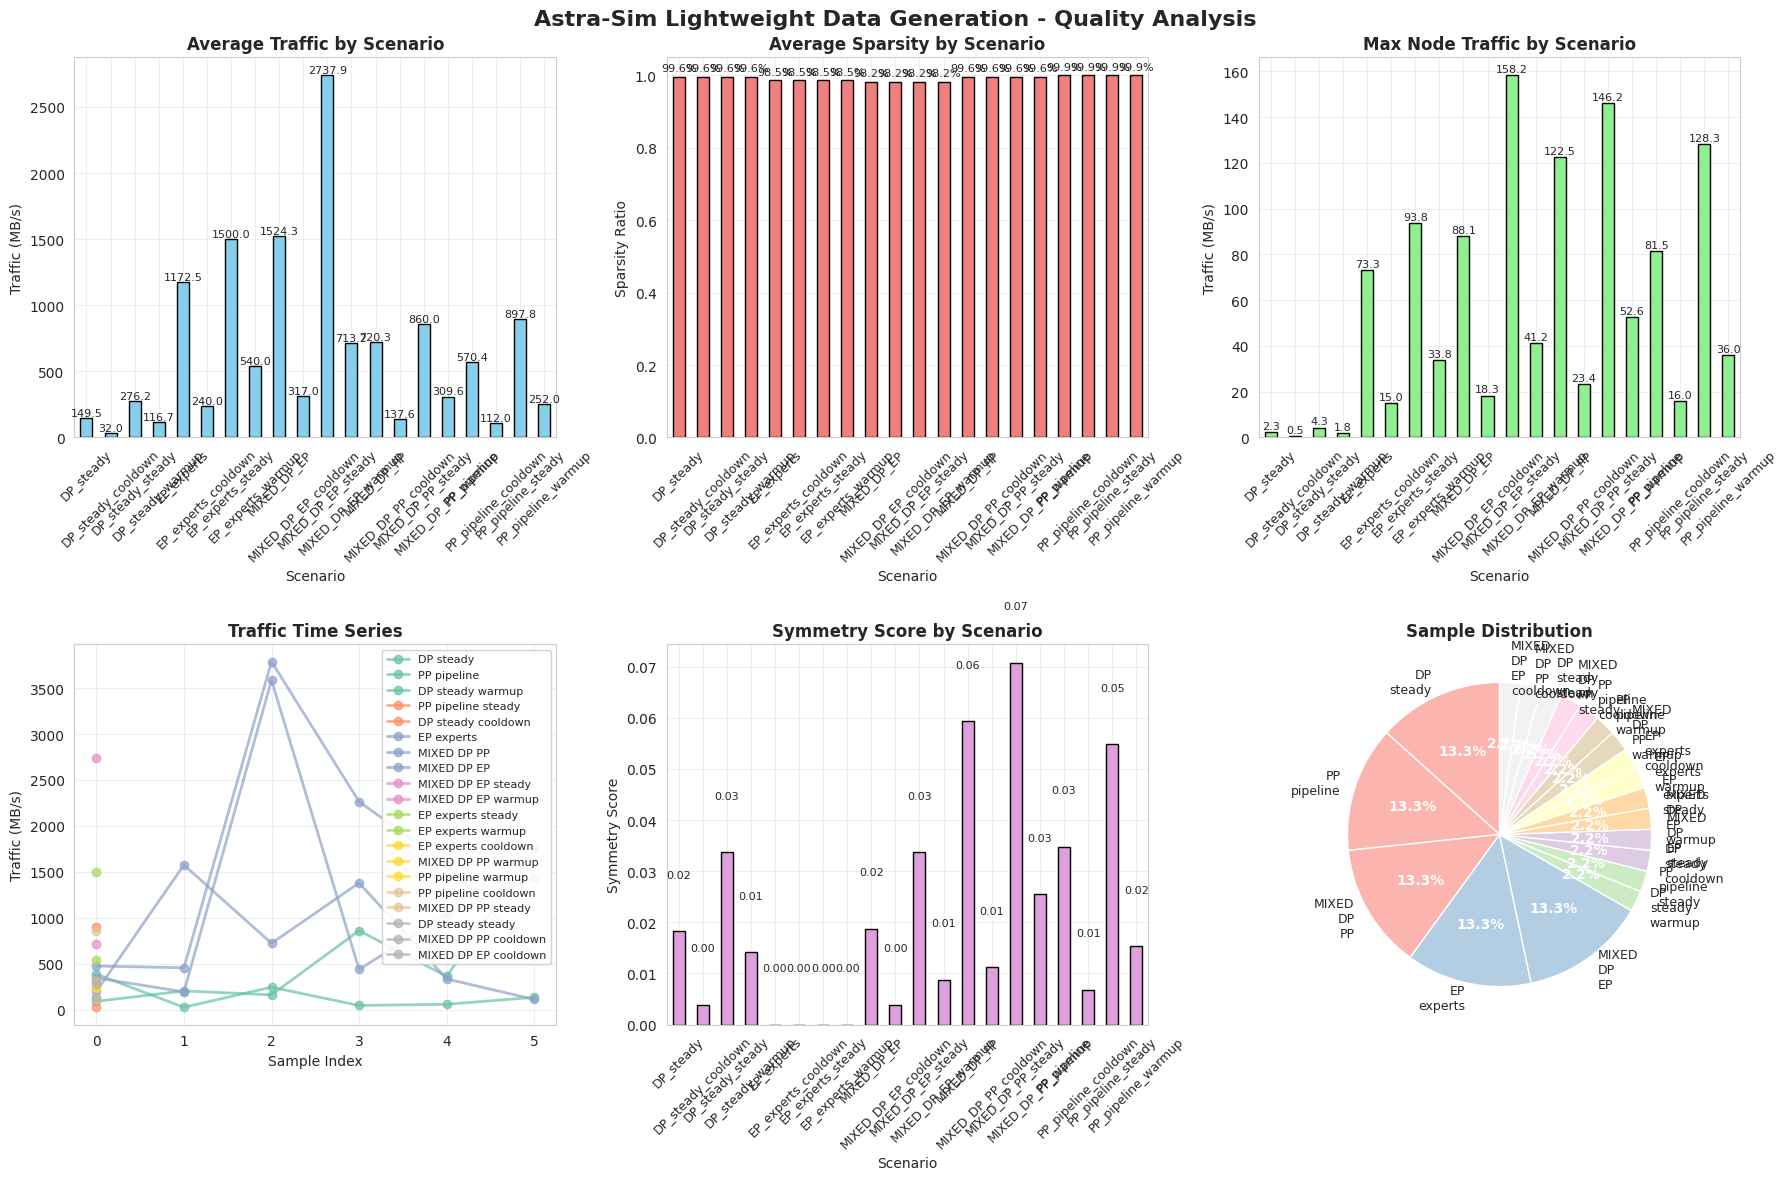

✅ Visualization saved to: ./visualizations/data_quality_analysis.png

Data Summary Statistics
Total Samples: 45
Number of Scenarios: 20
Average Traffic: 752.53 MB/s
Traffic Range: [25.92, 3787.29] MB/s
Average Sparsity: 99.17%


In [6]:
# ========================================
# Cell 6: Data Visualization (English Version)
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if data exists
if len(df_training) == 0:
    print("❌ Error: No training data available for visualization")
    print("Please check the output of cells 4 and 5")
else:
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.rcParams['font.family'] = 'DejaVu Sans'  # Ensure English font

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Astra-Sim Lightweight Data Generation - Quality Analysis',
                 fontsize=16, fontweight='bold')

    # 1. Traffic Distribution by Scenario
    ax1 = axes[0, 0]
    traffic_by_scenario = df_training.groupby('scenario')['total_traffic_mb_per_sec'].mean()
    traffic_by_scenario.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
    ax1.set_title('Average Traffic by Scenario', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Scenario', fontsize=10)
    ax1.set_ylabel('Traffic (MB/s)', fontsize=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(traffic_by_scenario):
        ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

    # 2. Sparsity Distribution
    ax2 = axes[0, 1]
    sparsity_by_scenario = df_training.groupby('scenario')['sparsity'].mean()
    sparsity_by_scenario.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black')
    ax2.set_title('Average Sparsity by Scenario', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Scenario', fontsize=10)
    ax2.set_ylabel('Sparsity Ratio', fontsize=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.grid(True, alpha=0.3)

    # Add percentage labels
    for i, v in enumerate(sparsity_by_scenario):
        ax2.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom', fontsize=8)

    # 3. Hotspot Traffic
    ax3 = axes[0, 2]
    hotspot_by_scenario = df_training.groupby('scenario')['max_node_send_traffic'].mean()
    hotspot_by_scenario.plot(kind='bar', ax=ax3, color='lightgreen', edgecolor='black')
    ax3.set_title('Max Node Traffic by Scenario', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Scenario', fontsize=10)
    ax3.set_ylabel('Traffic (MB/s)', fontsize=10)
    ax3.tick_params(axis='x', rotation=45, labelsize=9)
    ax3.grid(True, alpha=0.3)

    for i, v in enumerate(hotspot_by_scenario):
        ax3.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

    # 4. Traffic Time Series
    ax4 = axes[1, 0]
    unique_scenarios = df_training['scenario'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(unique_scenarios)))

    for idx, scenario in enumerate(unique_scenarios):
        scenario_data = df_training[df_training['scenario'] == scenario]
        if len(scenario_data) > 0:
            # Use simple scenario names for legend
            label = scenario.replace('_10steps', '').replace('_', ' ')
            ax4.plot(range(len(scenario_data)),
                    scenario_data['total_traffic_mb_per_sec'].values,
                    marker='o', label=label, alpha=0.7, color=colors[idx], linewidth=2)

    ax4.set_title('Traffic Time Series', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Sample Index', fontsize=10)
    ax4.set_ylabel('Traffic (MB/s)', fontsize=10)
    ax4.legend(fontsize=8, loc='best', framealpha=0.9)
    ax4.grid(True, alpha=0.3)

    # 5. Symmetry Analysis
    ax5 = axes[1, 1]
    symmetry_by_scenario = df_training.groupby('scenario')['symmetry_score'].mean()
    symmetry_by_scenario.plot(kind='bar', ax=ax5, color='plum', edgecolor='black')
    ax5.set_title('Symmetry Score by Scenario', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Scenario', fontsize=10)
    ax5.set_ylabel('Symmetry Score', fontsize=10)
    ax5.tick_params(axis='x', rotation=45, labelsize=9)
    ax5.grid(True, alpha=0.3)

    for i, v in enumerate(symmetry_by_scenario):
        ax5.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

    # 6. Sample Distribution (Pie Chart)
    ax6 = axes[1, 2]
    scenario_counts = df_training['scenario'].value_counts()

    # Simplify labels for pie chart
    labels = [s.replace('_10steps', '').replace('_', '\n') for s in scenario_counts.index]
    colors_pie = plt.cm.Pastel1(np.linspace(0, 1, len(scenario_counts)))

    wedges, texts, autotexts = ax6.pie(
        scenario_counts.values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_pie,
        textprops={'fontsize': 9}
    )

    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    ax6.set_title('Sample Distribution', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('./visualizations/data_quality_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Visualization saved to: ./visualizations/data_quality_analysis.png")

    # Print summary statistics
    print("\n" + "="*60)
    print("Data Summary Statistics")
    print("="*60)
    print(f"Total Samples: {len(df_training)}")
    print(f"Number of Scenarios: {df_training['scenario'].nunique()}")
    print(f"Average Traffic: {df_training['total_traffic_mb_per_sec'].mean():.2f} MB/s")
    print(f"Traffic Range: [{df_training['total_traffic_mb_per_sec'].min():.2f}, "
          f"{df_training['total_traffic_mb_per_sec'].max():.2f}] MB/s")
    print(f"Average Sparsity: {df_training['sparsity'].mean():.2%}")
    print("="*60)


📋 Available Scenarios: ['DP_steady_steady_dragonfly', 'DP_steady_steady_torus', 'MIXED_DP_PP_steady_dragonfly', 'EP_experts_steady_dragonfly', 'MIXED_DP_EP_steady_dragonfly', 'MIXED_DP_PP_steady_torus', 'MIXED_DP_EP_steady_torus', 'PP_pipeline_steady_torus', 'PP_pipeline_steady_dragonfly', 'EP_experts_steady_torus']


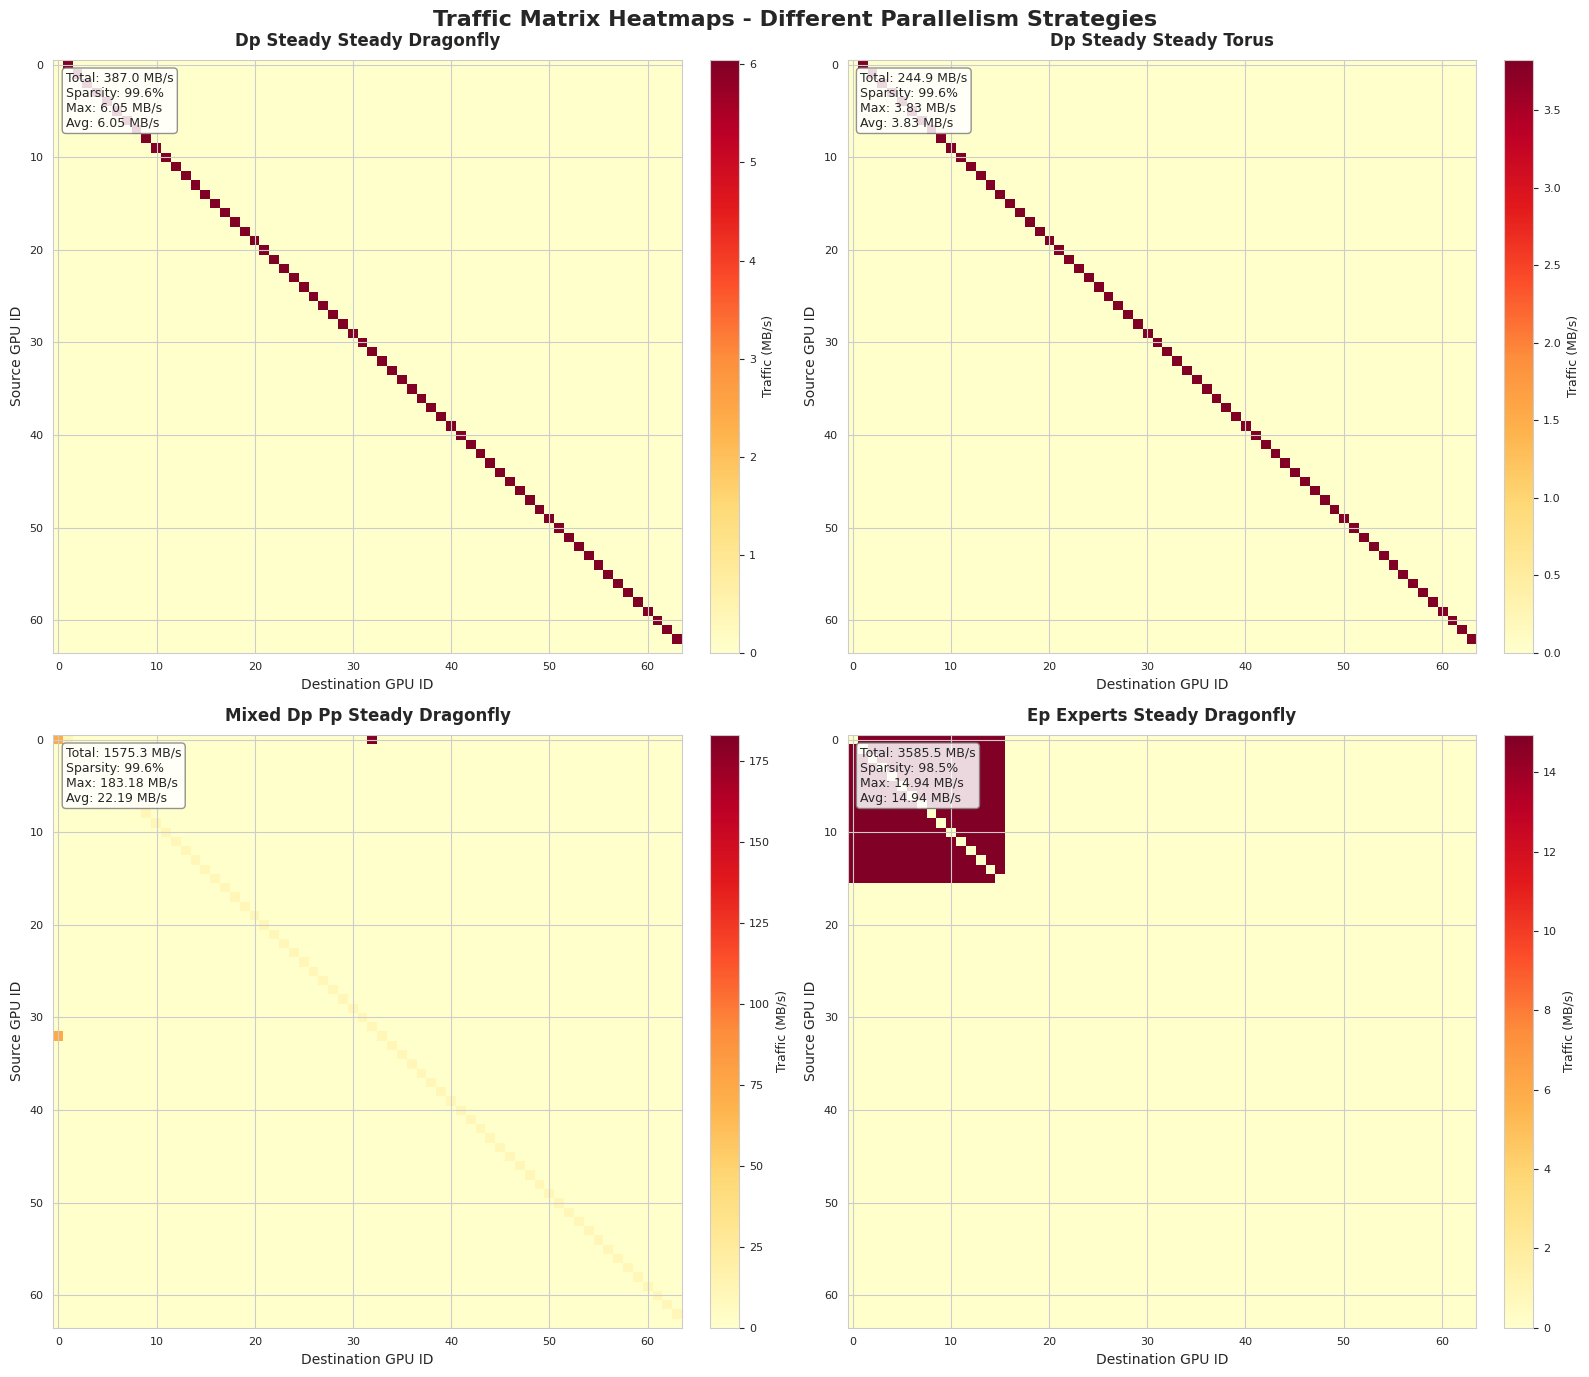

✅ Heatmap saved to: ./visualizations/traffic_matrices_heatmap.png

Traffic Matrix Statistics

DP_steady_steady_dragonfly:
  Shape: (128, 128)
  Total Traffic: 386.96 MB/s
  Sparsity: 99.61%
  Max Traffic: 6.05 MB/s
  Non-zero Elements: 64

DP_steady_steady_torus:
  Shape: (128, 128)
  Total Traffic: 244.90 MB/s
  Sparsity: 99.61%
  Max Traffic: 3.83 MB/s
  Non-zero Elements: 64

MIXED_DP_PP_steady_dragonfly:
  Shape: (128, 128)
  Total Traffic: 1575.35 MB/s
  Sparsity: 99.57%
  Max Traffic: 183.18 MB/s
  Non-zero Elements: 71

EP_experts_steady_dragonfly:
  Shape: (128, 128)
  Total Traffic: 3585.51 MB/s
  Sparsity: 98.54%
  Max Traffic: 14.94 MB/s
  Non-zero Elements: 240


In [7]:
# ========================================
# Cell 7: Traffic Matrix Heatmap Visualization (English Version)
# ========================================

import matplotlib.pyplot as plt
import numpy as np

# Check if matrices exist
if len(matrices_dict) == 0:
    print("❌ Error: No traffic matrices available for visualization")
else:
    # Get available scenarios
    available_scenarios = list(matrices_dict.keys())
    print(f"📋 Available Scenarios: {available_scenarios}")

    # Select scenarios to plot (up to 4)
    scenarios_to_plot = available_scenarios[:min(4, len(available_scenarios))]

    if len(scenarios_to_plot) == 0:
        print("❌ No scenarios available for visualization")
    else:
        # Create subplots
        num_plots = len(scenarios_to_plot)

        if num_plots == 1:
            fig, axes = plt.subplots(1, 1, figsize=(10, 8))
            axes = [axes]
        elif num_plots == 2:
            fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        elif num_plots == 3:
            fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        else:
            fig, axes = plt.subplots(2, 2, figsize=(16, 14))
            axes = axes.flatten()

        fig.suptitle('Traffic Matrix Heatmaps - Different Parallelism Strategies',
                     fontsize=16, fontweight='bold')

        for idx, scenario in enumerate(scenarios_to_plot):
            # Get matrix
            matrix = matrices_dict[scenario]

            # For visualization, only show first 64x64 subset
            matrix_subset = matrix[:64, :64]

            ax = axes[idx]

            # Plot heatmap
            im = ax.imshow(matrix_subset, cmap='YlOrRd', aspect='auto',
                          interpolation='nearest', vmin=0)

            # Clean scenario name for title
            title = scenario.replace('_10steps', '').replace('_', ' ').title()
            ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Destination GPU ID', fontsize=10)
            ax.set_ylabel('Source GPU ID', fontsize=10)

            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Traffic (MB/s)', fontsize=9)
            cbar.ax.tick_params(labelsize=8)

            # Calculate statistics
            total_traffic = np.sum(matrix)
            sparsity = np.sum(matrix == 0) / matrix.size
            max_traffic = np.max(matrix)
            avg_traffic = np.mean(matrix[matrix > 0]) if np.any(matrix > 0) else 0

            # Add statistics box
            stats_text = (
                f'Total: {total_traffic:.1f} MB/s\n'
                f'Sparsity: {sparsity:.1%}\n'
                f'Max: {max_traffic:.2f} MB/s\n'
                f'Avg: {avg_traffic:.2f} MB/s'
            )

            ax.text(0.02, 0.98, stats_text,
                   transform=ax.transAxes, fontsize=9,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white',
                           alpha=0.85, edgecolor='gray'))

            # Set tick parameters
            ax.tick_params(axis='both', labelsize=8)

        # Hide extra subplots if any
        if num_plots == 4:
            pass  # All subplots used
        elif num_plots < 4 and num_plots > 1:
            for idx in range(len(scenarios_to_plot), len(axes)):
                axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig('./visualizations/traffic_matrices_heatmap.png',
                   dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Heatmap saved to: ./visualizations/traffic_matrices_heatmap.png")

        # Print detailed statistics
        print("\n" + "="*60)
        print("Traffic Matrix Statistics")
        print("="*60)
        for scenario in scenarios_to_plot:
            matrix = matrices_dict[scenario]
            print(f"\n{scenario}:")
            print(f"  Shape: {matrix.shape}")
            print(f"  Total Traffic: {np.sum(matrix):.2f} MB/s")
            print(f"  Sparsity: {np.sum(matrix == 0) / matrix.size:.2%}")
            print(f"  Max Traffic: {np.max(matrix):.2f} MB/s")
            print(f"  Non-zero Elements: {np.count_nonzero(matrix)}")
        print("="*60)


DATA QUALITY VALIDATION REPORT

1️⃣  DATA COMPLETENESS
   Total Samples: 45
   Number of Scenarios: 20
   Missing Values: 0
   ✅ Status: PASS

2️⃣  TRAFFIC REASONABILITY
   Average Total Traffic: 752.53 MB/s
   Traffic Range: [25.92, 3787.29] MB/s
   Standard Deviation: 897.32 MB/s
   Outliers: 4 (8.9%)
   ✅ Status: PASS

3️⃣  SCENARIO COVERAGE
   DP_steady                     :   6 samples
   PP_pipeline                   :   6 samples
   MIXED_DP_PP                   :   6 samples
   EP_experts                    :   6 samples
   MIXED_DP_EP                   :   6 samples
   DP_steady_warmup              :   1 samples
   PP_pipeline_steady            :   1 samples
   DP_steady_cooldown            :   1 samples
   MIXED_DP_EP_steady            :   1 samples
   MIXED_DP_EP_warmup            :   1 samples
   EP_experts_steady             :   1 samples
   EP_experts_warmup             :   1 samples
   EP_experts_cooldown           :   1 samples
   MIXED_DP_PP_warmup            :   1 sam

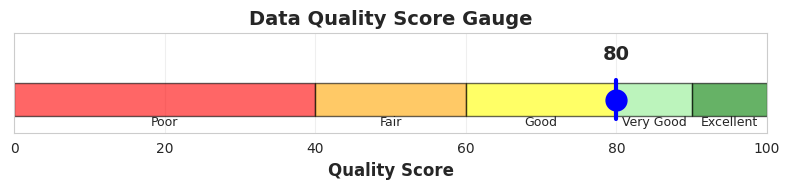


✅ Quality gauge saved to: ./visualizations/quality_score_gauge.png


In [8]:
# ========================================
# Cell 8: Data Quality Validation (English Version)
# ========================================

def validate_data_quality(df):
    """Validate data quality with English output"""

    if len(df) == 0:
        print("=" * 70)
        print("❌ ERROR: No data available for validation")
        print("=" * 70)
        return 0

    print("=" * 70)
    print("DATA QUALITY VALIDATION REPORT")
    print("=" * 70)

    # 1. Data Completeness
    print("\n1️⃣  DATA COMPLETENESS")
    print(f"   Total Samples: {len(df)}")
    print(f"   Number of Scenarios: {df['scenario'].nunique()}")
    print(f"   Missing Values: {df.isnull().sum().sum()}")
    completeness_pass = df.isnull().sum().sum() == 0
    print(f"   ✅ Status: {'PASS' if completeness_pass else 'FAIL'}")

    # 2. Traffic Reasonability
    print("\n2️⃣  TRAFFIC REASONABILITY")
    print(f"   Average Total Traffic: {df['total_traffic_mb_per_sec'].mean():.2f} MB/s")
    print(f"   Traffic Range: [{df['total_traffic_mb_per_sec'].min():.2f}, "
          f"{df['total_traffic_mb_per_sec'].max():.2f}] MB/s")
    print(f"   Standard Deviation: {df['total_traffic_mb_per_sec'].std():.2f} MB/s")

    # Check for outliers
    q1 = df['total_traffic_mb_per_sec'].quantile(0.25)
    q3 = df['total_traffic_mb_per_sec'].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df['total_traffic_mb_per_sec'] < q1 - 1.5*iqr) |
                  (df['total_traffic_mb_per_sec'] > q3 + 1.5*iqr)]
    outlier_ratio = len(outliers) / len(df)
    print(f"   Outliers: {len(outliers)} ({outlier_ratio*100:.1f}%)")
    reasonability_pass = outlier_ratio < 0.1
    print(f"   ✅ Status: {'PASS' if reasonability_pass else 'WARNING'}")

    # 3. Scenario Coverage
    print("\n3️⃣  SCENARIO COVERAGE")
    scenario_counts = df['scenario'].value_counts()
    for scenario, count in scenario_counts.items():
        scenario_clean = scenario.replace('_10steps', '')
        print(f"   {scenario_clean:30s}: {count:3d} samples")

    min_samples = scenario_counts.min()
    max_samples = scenario_counts.max()
    balance_ratio = min_samples / max_samples if max_samples > 0 else 0
    print(f"   Balance Ratio: {balance_ratio:.2f}")
    coverage_pass = balance_ratio > 0.5
    print(f"   ✅ Status: {'PASS' if coverage_pass else 'WARNING'}")

    # 4. Feature Distribution
    print("\n4️⃣  FEATURE DISTRIBUTION")
    print(f"   Sparsity Range: [{df['sparsity'].min():.2%}, {df['sparsity'].max():.2%}]")

    # Check scenario-specific features
    dp_scenarios = df[df['scenario'].str.contains('DP', case=False, na=False)]
    pp_scenarios = df[df['scenario'].str.contains('PP', case=False, na=False)]
    ep_scenarios = df[df['scenario'].str.contains('EP', case=False, na=False)]

    if len(dp_scenarios) > 0:
        print(f"   DP Scenario Sparsity: {dp_scenarios['sparsity'].mean():.2%}")
    if len(pp_scenarios) > 0:
        print(f"   PP Scenario Sparsity: {pp_scenarios['sparsity'].mean():.2%}")
    if len(ep_scenarios) > 0:
        print(f"   EP Scenario Sparsity: {ep_scenarios['sparsity'].mean():.2%}")

    # Check expected pattern (DP should be less sparse than PP)
    expected_pattern = True
    if len(dp_scenarios) > 0 and len(pp_scenarios) > 0:
        dp_sparse = dp_scenarios['sparsity'].mean()
        pp_sparse = pp_scenarios['sparsity'].mean()
        expected_pattern = dp_sparse < pp_sparse
        print(f"   Pattern Check (DP < PP sparsity): {expected_pattern}")

    distribution_pass = expected_pattern
    print(f"   ✅ Status: {'PASS' if distribution_pass else 'WARNING'}")

    # 5. Dynamic Characteristics
    print("\n5️⃣  DYNAMIC CHARACTERISTICS")
    mean_traffic = df['total_traffic_mb_per_sec'].mean()
    cv = df['total_traffic_mb_per_sec'].std() / mean_traffic if mean_traffic > 0 else 0
    print(f"   Coefficient of Variation: {cv:.2f}")
    print(f"   Hotspot Traffic Range: [{df['max_node_send_traffic'].min():.2f}, "
          f"{df['max_node_send_traffic'].max():.2f}] MB/s")
    dynamic_pass = cv > 0.3
    print(f"   ✅ Status: {'PASS' if dynamic_pass else 'WARNING'}")

    # 6. Overall Score
    print("\n" + "=" * 70)
    checks_passed = sum([
        completeness_pass,
        reasonability_pass,
        coverage_pass,
        distribution_pass,
        dynamic_pass
    ])
    total_checks = 5
    score = checks_passed / total_checks * 100

    print(f"OVERALL QUALITY SCORE: {score:.0f}/100")
    print()
    if score >= 80:
        print("✅ EXCELLENT - Data is ready for training!")
    elif score >= 60:
        print("⚠️  GOOD - Data is acceptable, review warnings")
    else:
        print("❌ POOR - Data quality needs improvement")

    print("=" * 70)

    # Detailed statistics table
    print("\n" + "=" * 70)
    print("DETAILED STATISTICS")
    print("=" * 70)
    print(df.describe().to_string())
    print("=" * 70)

    return score

# Run validation
quality_score = validate_data_quality(df_training)

# Additional visualization: Quality score gauge
if len(df_training) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(8, 2))

    # Create horizontal bar for quality score
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
    boundaries = [0, 40, 60, 80, 90, 100]

    for i in range(len(boundaries)-1):
        ax.barh(0, boundaries[i+1]-boundaries[i], left=boundaries[i],
               height=0.5, color=colors[i], alpha=0.6, edgecolor='black')

    # Add score marker
    ax.plot([quality_score, quality_score], [-0.3, 0.3], 'b-', linewidth=3)
    ax.plot(quality_score, 0, 'bo', markersize=15)
    ax.text(quality_score, 0.6, f'{quality_score:.0f}',
           ha='center', fontsize=14, fontweight='bold')

    ax.set_xlim(0, 100)
    ax.set_ylim(-0.5, 1)
    ax.set_xlabel('Quality Score', fontsize=12, fontweight='bold')
    ax.set_title('Data Quality Score Gauge', fontsize=14, fontweight='bold')
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)

    # Add labels
    ax.text(20, -0.4, 'Poor', ha='center', fontsize=9)
    ax.text(50, -0.4, 'Fair', ha='center', fontsize=9)
    ax.text(70, -0.4, 'Good', ha='center', fontsize=9)
    ax.text(85, -0.4, 'Very Good', ha='center', fontsize=9)
    ax.text(95, -0.4, 'Excellent', ha='center', fontsize=9)

    plt.tight_layout()
    plt.savefig('./visualizations/quality_score_gauge.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Quality gauge saved to: ./visualizations/quality_score_gauge.png")


In [9]:
pip install torch numpy pandas scikit-learn matplotlib seaborn tqdm


In [17]:
!python traffic_prediction_lstm_fixed.py


2025-12-04 05:59:52.767776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764827992.792207    8942 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764827992.799661    8942 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764827992.817537    8942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764827992.817574    8942 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764827992.817579    8942 computation_placer.cc:177] computation placer alr